# Band Gap, Formation Energy, and Volume Prediction using *Ward 2016* Method

This notebook uses the method from [Ward 2016](https://www.nature.com/articles/npjcompumats201628) to predict band gap, formation energy, and specific volume of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
training_file = "datasets/oqmd_all.data"
delimiter = ' '
comp_col = "comp"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~300000 compounds with data extracted from the Open Quantum Materials Database (OQMD)

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
        
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))

    return training_set

training_set = load_training_set(training_file, delimiter)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.892,17.8351,NaN,0.0,0.004605,0.00460472666667
1,Mg1,-1.5396,22.9639,NaN,0.0,0.002719,0.00271877166667
2,Kr1,0.011256,41.4146,NaN,7.367,0.015315,0.015314775
3,Na1,-1.2991,32.9826,NaN,0.0,0.003780,0.00377956333333
4,Pd1,-5.15853,15.2088,NaN,0.0,0.018186,0.0181856433333
5,Fe1,-8.12585,11.5973,2.52045186667,0.0,0.182049,0.182048713333
6,Gd1,-4.65402,32.2627,-0.00223023333333,0.0,0.001047,0.00104724916667
7,Hf1,-9.9232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465
8,Ho1,-4.57663,30.5482,0.0072197,0.0,0.000166,0.00055882666667
9,In1,-2.71483,26.816,NaN,0.0,0.005113,0.00511323666667


### Get groundstate of each compound

For compounds that appear more than once in the training set, only the lowest energy state is kept.

In [4]:
training_set['is_groundstate'] = False

In [5]:
%%time
for gid,group in training_set.groupby(comp_col):
    group = group.sort_values('energy_pa', ascending=True)
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True

CPU times: user 4min 9s, sys: 1.17 s, total: 4min 10s
Wall time: 4min 12s


In [6]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
print('Removed %d/%d entires'%(original_count - len(training_set), original_count))

Removed 118652/347328 entires


## Create PyMatGen Composition objects

In [7]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)

training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
4,Pd1,-5.15853,15.2088,NaN,0.0,0.018186,0.0181856433333,True,(Pd)
7,Hf1,-9.9232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf)
9,In1,-2.71483,26.816,NaN,0.0,0.005113,0.00511323666667,True,(In)
15,Mo1,-10.4191,15.9204,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo)
16,Nb1,-9.80092,18.6733,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb)
18,Ni1,-5.55216,10.7022,0.611777266667,0.0,0.014457,0.01445706,True,(Ni)
19,Os1,-11.1811,14.2827,7.71e-05,0.0,0.044841,0.04484125,True,(Os)
21,Pb1,-3.69299,31.1795,NaN,0.0,0.010978,0.0109780066667,True,(Pb)
22,Pm1,-4.74148,34.2306,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm)
23,Pr1,-4.7688,35.9841,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr)


## Compute descriptors using MatMiner
Here, we compute 145 composition based attributes as described in *Ward 2016* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [8]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.Stoichiometry().featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElementProperty().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbital().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.IonProperty().featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

#%lprun -f calc_attributes calc_attributes()

all_descriptors, attr_names = calc_attributes(training_set)
print np.shape(all_descriptors)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


(228676, 158)
CPU times: user 12min 54s, sys: 4.57 s, total: 12min 58s
Wall time: 13min 1s


## Predicting band gaps

In [9]:
#Drop NaN values from training set

training_set_use = all_descriptors.replace("None", np.nan)
training_set_use = training_set_use.replace(np.inf, np.nan)
training_set_use = training_set_use.dropna()

training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj,0-norm,...,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons,Avg Ionic Char,Max Ionic Char,compound possible
7,Hf1,-9.9232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf),1.0,...,14.000000,0.000000,2.000000,0.111111,0.777778,0.000000,0.111111,0.000000,0.000000,1.0
15,Mo1,-10.4191,15.9204,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo),1.0,...,0.000000,0.000000,1.000000,0.833333,0.000000,0.000000,0.166667,0.000000,0.000000,1.0
16,Nb1,-9.80092,18.6733,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb),1.0,...,0.000000,0.000000,1.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,1.0
18,Ni1,-5.55216,10.7022,0.611777266667,0.0,0.014457,0.01445706,True,(Ni),1.0,...,0.000000,0.000000,2.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,1.0
19,Os1,-11.1811,14.2827,7.71e-05,0.0,0.044841,0.04484125,True,(Os),1.0,...,14.000000,0.000000,2.000000,0.272727,0.636364,0.000000,0.090909,0.000000,0.000000,1.0
22,Pm1,-4.74148,34.2306,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm),1.0,...,5.000000,0.000000,2.000000,0.000000,0.714286,0.000000,0.285714,0.000000,0.000000,1.0
23,Pr1,-4.7688,35.9841,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr),1.0,...,3.000000,0.000000,2.000000,0.000000,0.600000,0.000000,0.400000,0.000000,0.000000,1.0
30,Sm1,-4.71102,33.5829,0.0106331333333,0.0,0.003747,0.00374735916667,True,(Sm),1.0,...,6.000000,0.000000,2.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.000000,1.0
41,Tc1,-10.3452,14.4763,-0.00934373333333,0.0,0.015549,0.015548835,True,(Tc),1.0,...,0.000000,0.000000,2.000000,0.714286,0.000000,0.000000,0.285714,0.000000,0.000000,1.0
60,Ac1,-4.10272,44.8796,0.0010475,0.0,0.003286,0.00328580916667,True,(Ac),1.0,...,0.000000,0.000000,2.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,1.0


In [10]:
#Band gap data
bandgaps = np.array(training_set_use["bandgap"], dtype=float)
print bandgaps

#Band gap range data
bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

[ 0.  0.  0. ...,  0.  0.  0.]


### Predict band gap range using classifiers

In [11]:
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], bg_range)
prediction = model1.predict(training_set_use[attr_names])

In [12]:
pd.crosstab(bg_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,113266,3,0,1
1,91,1746,4,2
2,11,8,1489,2
3,4,1,8,818


In [13]:
model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], bg_range)
prediction = model2.predict(training_set_use[attr_names])

In [14]:
pd.crosstab(bg_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,113270,0,0,0
1,0,1843,0,0
2,0,0,1510,0
3,0,0,0,831


In [15]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [16]:
prediction = rf_model.predict(training_set_use[attr_names])

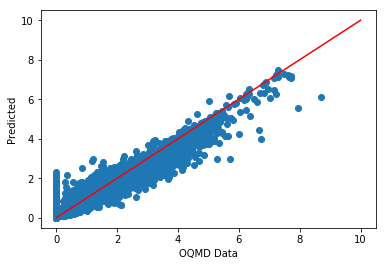

In [17]:
plt.scatter(bandgaps, prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [18]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.0558217294383
CPU times: user 13min 4s, sys: 2.45 s, total: 13min 6s
Wall time: 13min 10s


### Decision Tree Regressor

In [19]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], bandgaps)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [20]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

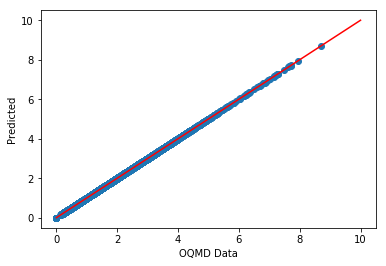

In [21]:
plt.scatter(bandgaps, dt_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [22]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.0607971089574
CPU times: user 2min 3s, sys: 943 ms, total: 2min 4s
Wall time: 2min 5s


## Predicting formation energy

In [23]:
#Discretize into positive/negative formation energy

delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['p' 'p' 'p' ..., 'n' 'n' 'n']


In [24]:
#Random Forest Classifier

model1 = RandomForestClassifier(n_estimators=8, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [25]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,35212,78
p,284,81880


In [26]:
#Decision Trees Classifier

model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], energy_range)
prediction = model2.predict(training_set_use[attr_names])

In [27]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,35290,0
p,0,82164


In [28]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
prediction = rf_model.predict(training_set_use[attr_names])

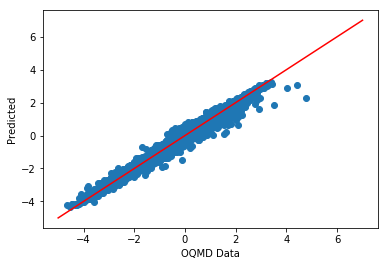

In [30]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [31]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.184706088611
CPU times: user 9min 37s, sys: 2.04 s, total: 9min 39s
Wall time: 9min 40s


### Decision Tree

In [32]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [33]:
prediction = dt_model.predict(training_set_use[attr_names])

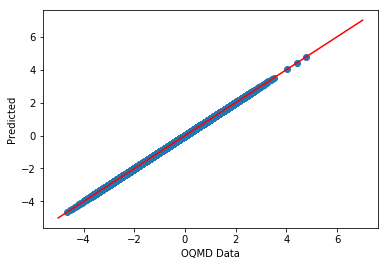

In [34]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [35]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.247429934163
CPU times: user 1min 28s, sys: 626 ms, total: 1min 28s
Wall time: 1min 28s


## Predicting volume per atom

In [36]:
#Remove volume outlier
max_value = max(np.array(training_set_use["volume_pa"], dtype=float))
print max_value
training_set_vol = training_set_use.replace(str(max_value), np.nan)
print max(np.array(training_set_vol["volume_pa"], dtype=float))

98.7174
98.7174


In [37]:
training_set_vol = training_set_vol.dropna()

In [38]:
volume_pa = np.array(training_set_vol["volume_pa"], dtype=float)
print volume_pa

#Band gap range data
vol_range = np.zeros(np.shape(volume_pa), dtype=str)
for i in range(len(volume_pa)):
    if volume_pa[i] < 20:
        vol_range[i] = "0"
    elif volume_pa[i] >= 20 and volume_pa[i] < 40:
        vol_range[i] = "1"
    elif volume_pa[i] >= 40 and volume_pa[i] < 60:
        vol_range[i] = "2"
    elif volume_pa[i] >= 60:
        vol_range[i] = "3"


[ 22.3676   15.9204   18.6733  ...,   9.95938   9.55423  11.9021 ]


In [39]:
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_vol[attr_names], vol_range)
prediction = model1.predict(training_set_vol[attr_names])

In [40]:
pd.crosstab(vol_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,51159,33,0,0
1,139,62407,6,0
2,0,39,3471,0
3,0,0,5,195


In [41]:
model2 = DecisionTreeClassifier()
model2.fit(training_set_vol[attr_names], vol_range)
prediction = model2.predict(training_set_vol[attr_names])

In [42]:
pd.crosstab(vol_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,51192,0,0,0
1,0,62552,0,0
2,0,0,3510,0
3,0,0,0,200


In [43]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_vol[attr_names], volume_pa)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [44]:
prediction = rf_model.predict(training_set_vol[attr_names])

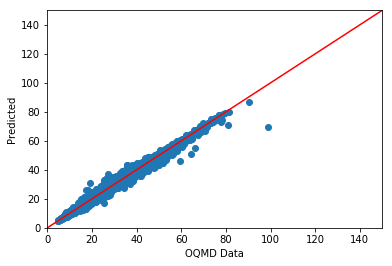

In [45]:
plt.scatter(volume_pa, prediction)
plt.plot(range(0,151), range(0,151), 'r')
plt.axis([0,150,0,150])
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [46]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_vol[attr_names], volume_pa, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

1.08147346501
CPU times: user 9min 10s, sys: 2.05 s, total: 9min 12s
Wall time: 9min 12s
